In [21]:
import numpy as np
import torch
import time
from scipy import stats
from torch import nn
from collections import defaultdict
from d2l import torch as d2l

import logging

logging.basicConfig(level=logging.INFO)
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch
from syne_tune.optimizer.baselines import ASHA

# 19.1. What Is Hyperparameter Optimization

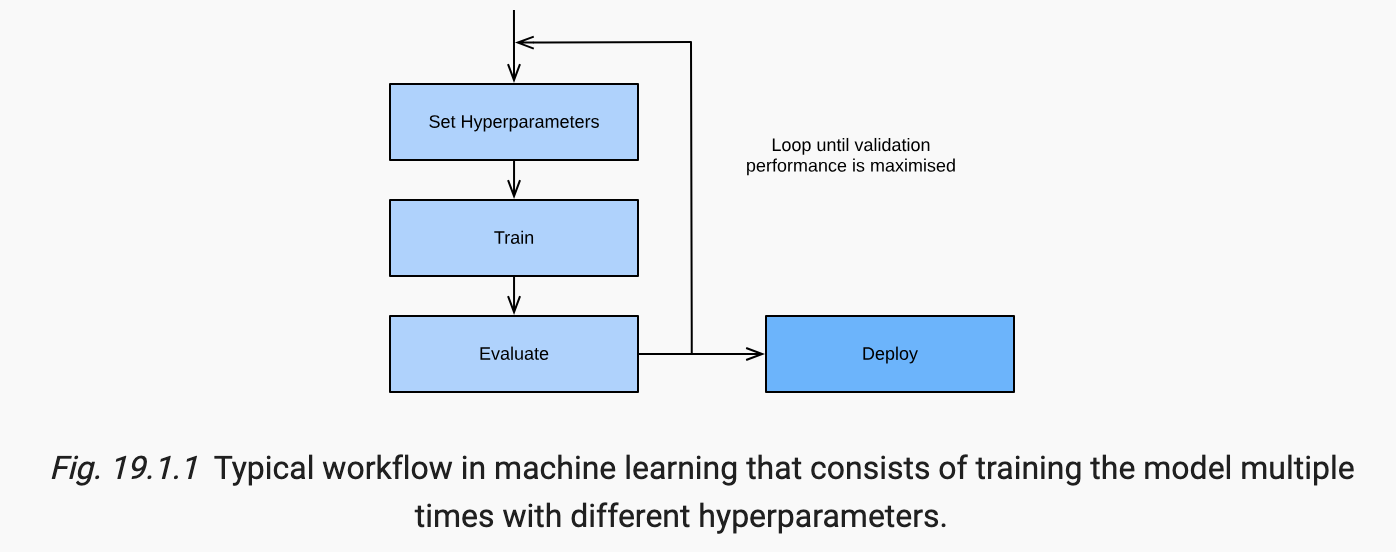

In [2]:
class HPOTrainer(d2l.Trainer):  # @save
    def validation_error(self):
        self.model.eval()
        accuracy = 0
        val_batch_idx = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)
            val_batch_idx += 1
        return 1 - accuracy / val_batch_idx

In [3]:
def hpo_objective_softmax_classification(config, max_epochs=8):
    learning_rate = config["learning_rate"]
    trainer = d2l.HPOTrainer(max_epochs=max_epochs)
    data = d2l.FashionMNIST(batch_size=16)
    model = d2l.SoftmaxRegression(num_outputs=10, lr=learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()

In [4]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}

## 19.1.2. Random Search

    validation_error = 0.1769999861717224


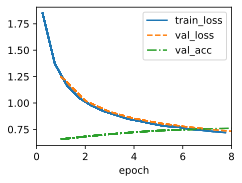

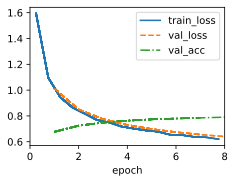

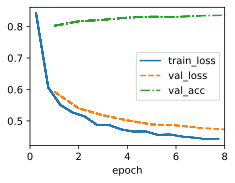

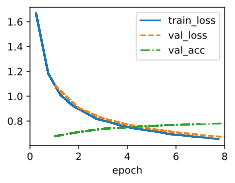

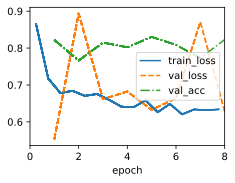

In [5]:
errors, values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f"Trial {i}: learning_rate = {learning_rate}")
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f"    validation_error = {y}")
    values.append(learning_rate)
    errors.append(y)

In [6]:
best_idx = np.argmin(errors)
print(f"optimal learning rate = {values[best_idx]}")

optimal learning rate = 0.008861506082562275


# 19.2. Hyperparameter Optimization API

## 19.2.1. Searcher

In [7]:
class HPOSearcher(d2l.HyperParameters):  # @save
    def sample_configuration() -> dict:
        raise NotImplementedError

    def update(self, config: dict, error: float, additional_info=None):
        pass

In [8]:
class RandomSearcher(HPOSearcher):  # @save
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()

    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else:
            result = {name: domain.rvs() for name, domain in self.config_space.items()}
        return result

## 19.2.2. Scheduler

In [9]:
class HPOScheduler(d2l.HyperParameters):  # @save
    def suggest(self) -> dict:
        raise NotImplementedError

    def update(self, config: dict, error: float, info=None):
        raise NotImplementedError

In [10]:
class BasicScheduler(HPOScheduler):  # @save
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()

    def suggest(self) -> dict:
        return self.searcher.sample_configuration()

    def update(self, config: dict, error: float, info=None):
        self.searcher.update(config, error, additional_info=info)

## 19.2.3. Tuner

In [11]:
class HPOTuner(d2l.HyperParameters):  # @save
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        # Bookeeping results for plotting
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []

    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f"Trial {i}: config = {config}")
            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())
            self.scheduler.update(config, error)
            runtime = time.time() - start_time
            self.bookkeeping(config, error, runtime)
            print(f"    error = {error}, runtime = {runtime}")

## 19.2.4. Bookkeeping the Performance of HPO Algorithms

In [12]:
@d2l.add_to_class(HPOTuner)  # @save
def bookkeeping(self, config: dict, error: float, runtime: float):
    self.records.append({"config": config, "error": error, "runtime": runtime})
    # Check if the last hyperparameter configuration performs better
    # than the incumbent
    if self.incumbent is None or self.incumbent_error > error:
        self.incumbent = config
        self.incumbent_error = error
    # Add current best observed performance to the optimization trajectory
    self.incumbent_trajectory.append(self.incumbent_error)
    # Update runtime
    self.current_runtime += runtime
    self.cumulative_runtime.append(self.current_runtime)

## 19.2.5. Example: Optimizing the Hyperparameters of a Convolutional Neural Network

In [13]:
def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):  # @save
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

In [14]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

    error = 0.1658385992050171, runtime = 17.9562566280365


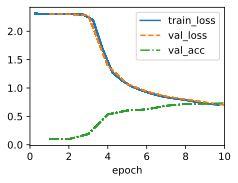

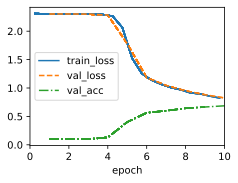

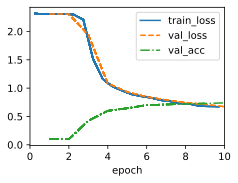

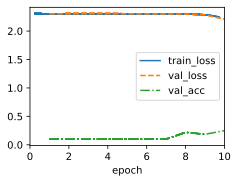

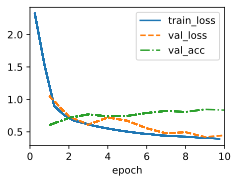

In [17]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

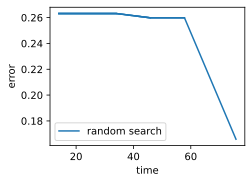

In [18]:
board = d2l.ProgressBoard(xlabel="time", ylabel="error")
for time_stamp, error in zip(tuner.cumulative_runtime, tuner.incumbent_trajectory):
    board.draw(time_stamp, error, "random search", every_n=1)

# 19.3. Asynchronous Random Search

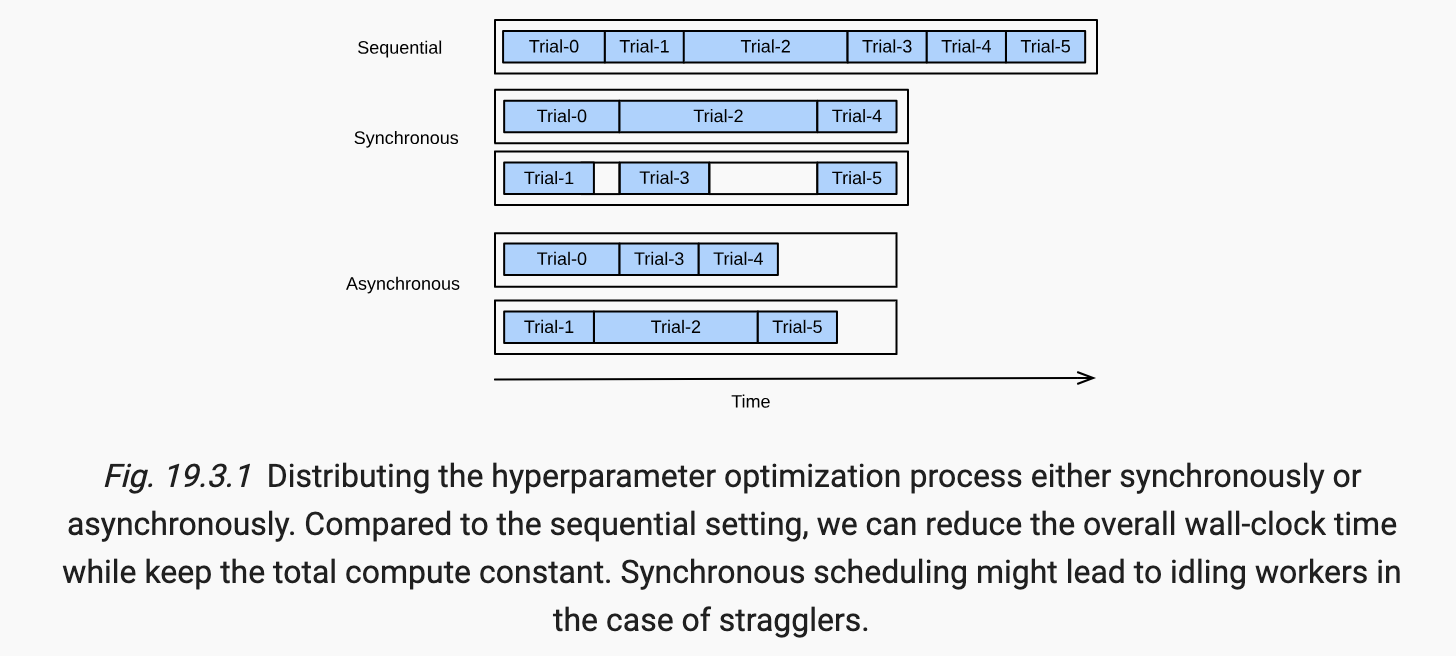

In [3]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter
    from d2l import torch as d2l

    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()
        validation_error = trainer.validation_error().cpu().detach().numpy()
        report(epoch=epoch, validation_error=float(validation_error))

In [4]:
n_workers = 2  # Needs to be <= the number of available GPUs

max_wallclock_time = 12 * 60  # 12 minutes

In [5]:
mode = "min"
metric = "validation_error"

In [6]:
config_space = {
    "learning_rate": loguniform(1e-2, 1),
    "batch_size": randint(32, 256),
    "max_epochs": 10,
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

In [7]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

In [8]:
scheduler = RandomSearch(
    config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
)

INFO:syne_tune.optimizer.schedulers.scheduler_searcher:Master random_seed = 733856339
INFO:syne_tune.optimizer.schedulers.scheduler_searcher:max_resource_level = 10, as inferred from config_space


In [9]:
stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)

tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)

In [10]:
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/pqian/syne-tune/python-entrypoint-2025-06-02-23-53-05-899
INFO:syne_tune.backend.local_backend:Detected 1 GPUs
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/pqian/miniconda3/envs/llama3/bin/python /home/pqian/miniconda3/envs/llama3/lib/python3.11/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root /home/pqian/syne-tune/python-entrypoint-2025-06-02-23-53-05-899/tune_function --tune_function_hash 3b9fec3ee3a5527b2f41330d374437c8 --st_checkpoint_dir /home/pqian/syne-tune/python-entrypoint-2025-06-02-23-53-05-899/0/checkpoints
INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/pqian/miniconda3/envs/llama3/bin/python /home/pqian/miniconda3/envs/llama3/lib/python3.11/site-packages

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0  Completed    10       0.100000         128          10     10          0.269581    17.534075
        1  Completed    10       0.071780         118          10     10          0.303872    18.279615
        2  Completed    10       0.021947          53          10     10          0.437223    24.310027
        3  Completed    10       0.015353         189          10     10          0.900002    15.065902
        4  Completed    10       0.126916          61          10     10          0.200125    22.974802
        5  Completed    10       0.027562         203          10     10          0.899526    15.751957
        6  Completed    10       0.047013         253          10     10          0.899759    12.873046
        7  Completed    10       0.056747         136          10     10          0.474673    17.483204

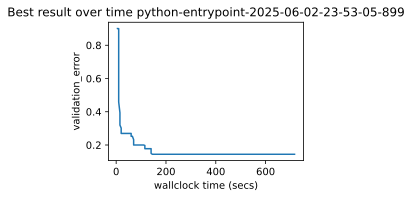

In [11]:
d2l.set_figsize()
tuning_experiment = load_experiment(tuner.name)
tuning_experiment.plot()

Text(0, 0.5, 'objective function')

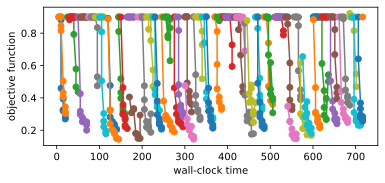

In [12]:
d2l.set_figsize([6, 2.5])
results = tuning_experiment.results

for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]
    d2l.plt.plot(df["st_tuner_time"], df["validation_error"], marker="o")

d2l.plt.xlabel("wall-clock time")
d2l.plt.ylabel("objective function")

# 19.4. Multi-Fidelity Hyperparameter Optimization

We start with running $N$ trials until the first rung $r_{\mathrm{min}}$. Sorting the validation errors, we keep the top $1 / \eta$ fraction (which amounts to $\eta^{K-1}$ configurations) and discard all the rest. The surviving trials are trained for the next rung ($r_{\mathrm{min}}\eta$ epochs), and the process is repeated. At each rung, a $1 / \eta$ fraction of trials survives and their training continues with a $\eta$ times larger budget. With this particular choice of $N$, only a single trial will be trained to the full budget $r_{max}$. Once such a round of successive halving is done, we start the next one with a new set of initial configurations, iterating until the total budget is spent.

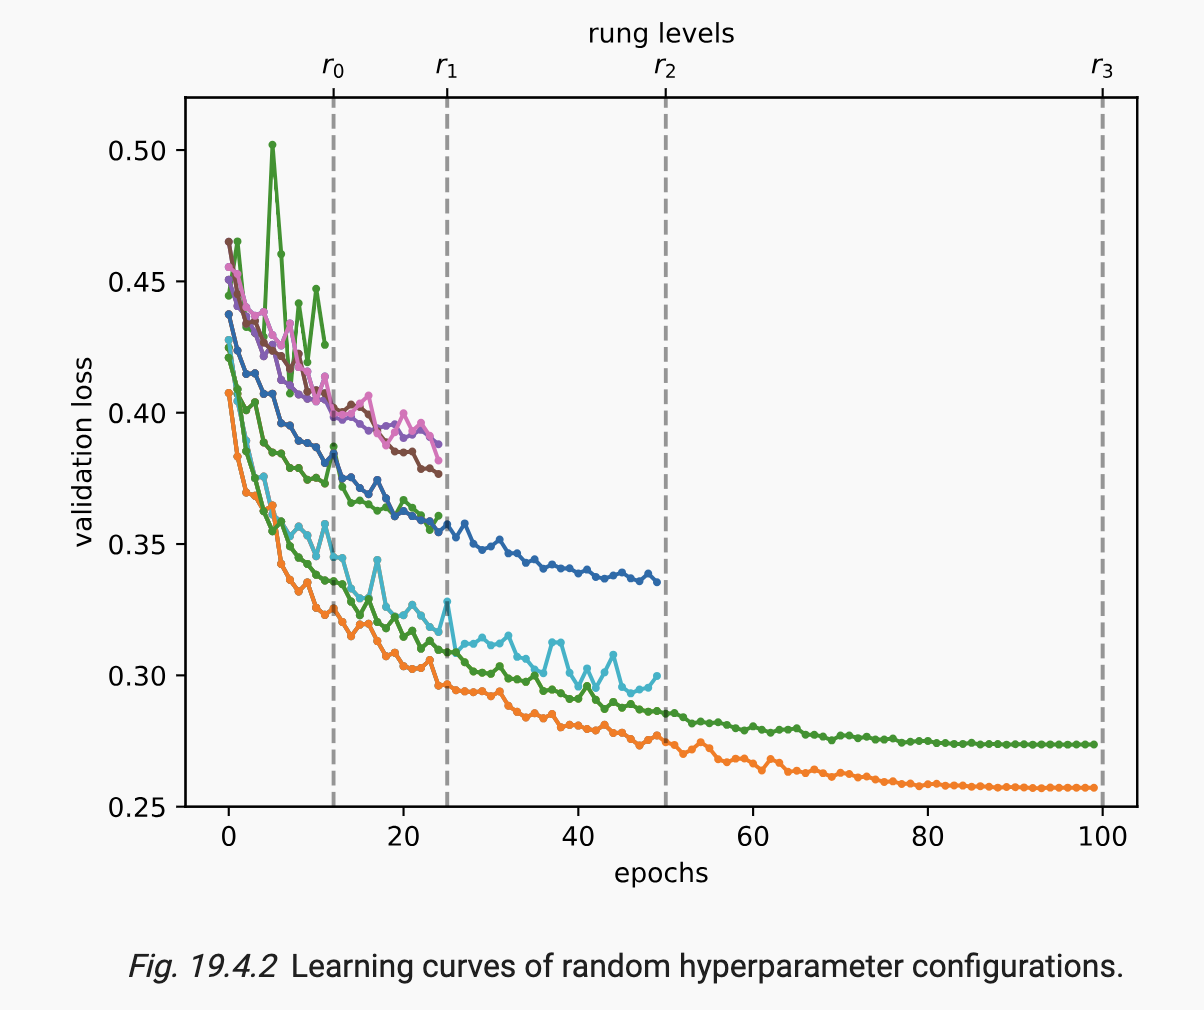

In [14]:
class SuccessiveHalvingScheduler(d2l.HPOScheduler):  # @save
    def __init__(self, searcher, eta, r_min, r_max, prefact=1):
        self.save_hyperparameters()
        # Compute K, which is later used to determine the number of configurations
        self.K = int(np.log(r_max / r_min) / np.log(eta))
        # Define the rungs
        self.rung_levels = [r_min * eta**k for k in range(self.K + 1)]
        if r_max not in self.rung_levels:
            # The final rung should be r_max
            self.rung_levels.append(r_max)
            self.K += 1
        # Bookkeeping
        self.observed_error_at_rungs = defaultdict(list)
        self.all_observed_error_at_rungs = defaultdict(list)
        # Our processing queue
        self.queue = []

In [15]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  # @save
def suggest(self):
    if len(self.queue) == 0:
        # Start a new round of successive halving
        # Number of configurations for the first rung:
        n0 = int(self.prefact * self.eta**self.K)
        for _ in range(n0):
            config = self.searcher.sample_configuration()
            config["max_epochs"] = self.r_min  # Set r = r_min
            self.queue.append(config)
    # Return an element from the queue
    return self.queue.pop()

In [16]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  # @save
def update(self, config: dict, error: float, info=None):
    ri = int(config["max_epochs"])  # Rung r_i
    # Update our searcher, e.g if we use Bayesian optimization later
    self.searcher.update(config, error, additional_info=info)
    self.all_observed_error_at_rungs[ri].append((config, error))
    if ri < self.r_max:
        # Bookkeeping
        self.observed_error_at_rungs[ri].append((config, error))
        # Determine how many configurations should be evaluated on this rung
        ki = self.K - self.rung_levels.index(ri)
        ni = int(self.prefact * self.eta**ki)
        # If we observed all configuration on this rung r_i, we estimate the
        # top 1 / eta configuration, add them to queue and promote them for
        # the next rung r_{i+1}
        if len(self.observed_error_at_rungs[ri]) >= ni:
            kiplus1 = ki - 1
            niplus1 = int(self.prefact * self.eta**kiplus1)
            best_performing_configurations = self.get_top_n_configurations(
                rung_level=ri, n=niplus1
            )
            riplus1 = self.rung_levels[self.K - kiplus1]  # r_{i+1}
            # Queue may not be empty: insert new entries at the beginning
            self.queue = [
                dict(config, max_epochs=riplus1)
                for config in best_performing_configurations
            ] + self.queue
            self.observed_error_at_rungs[ri] = []  # Reset

In [17]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  # @save
def get_top_n_configurations(self, rung_level, n):
    rung = self.observed_error_at_rungs[rung_level]
    if not rung:
        return []
    sorted_rung = sorted(rung, key=lambda x: x[1])
    return [x[0] for x in sorted_rung[:n]]

In [18]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2
num_gpus = 1

config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

    error = 0.18035435676574707, runtime = 14.19737195968628


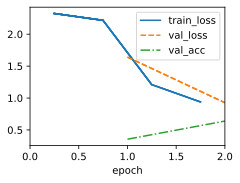

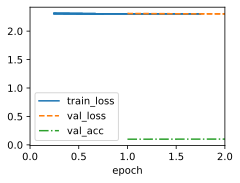

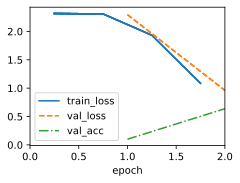

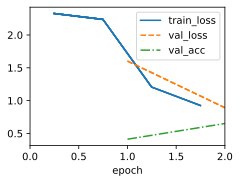

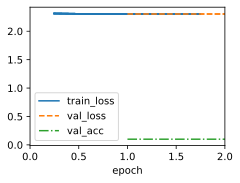

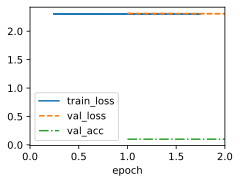

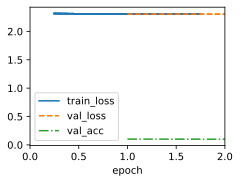

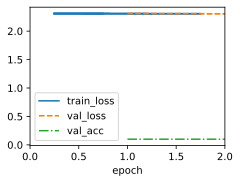

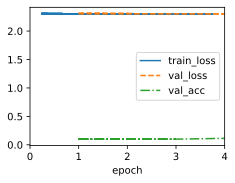

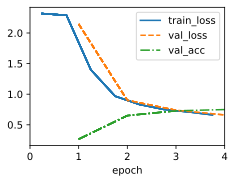

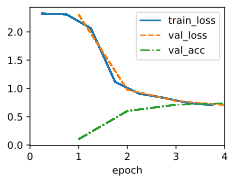

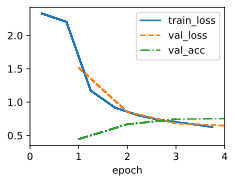

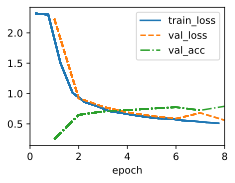

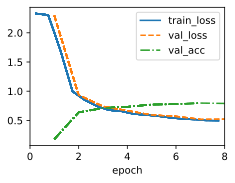

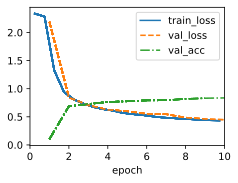

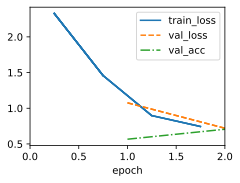

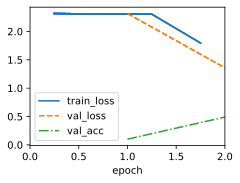

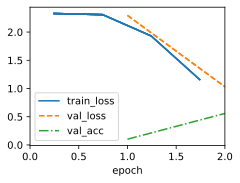

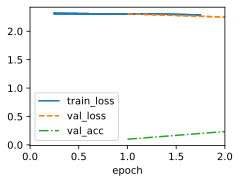

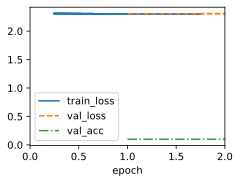

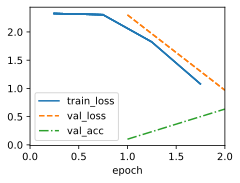

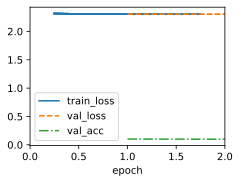

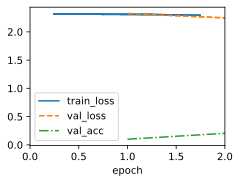

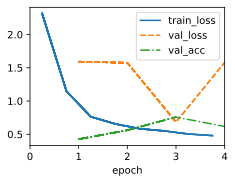

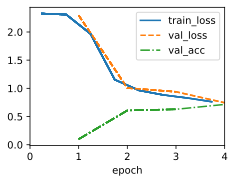

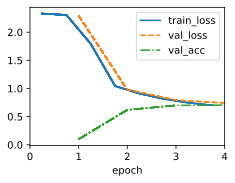

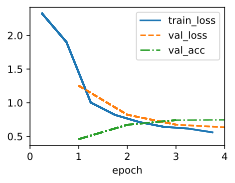

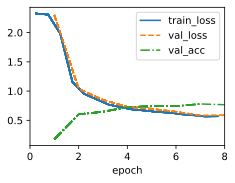

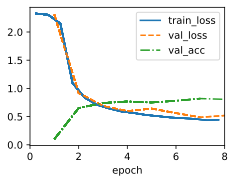

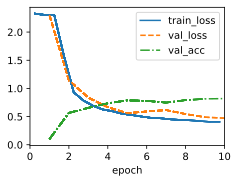

In [19]:
searcher = d2l.RandomSearcher(config_space, initial_config=initial_config)
scheduler = SuccessiveHalvingScheduler(
    searcher=searcher,
    eta=eta,
    r_min=min_number_of_epochs,
    r_max=max_number_of_epochs,
)
tuner = d2l.HPOTuner(
    scheduler=scheduler,
    objective=d2l.hpo_objective_lenet,
)
tuner.run(number_of_trials=30)

Text(0.5, 0, 'epochs')

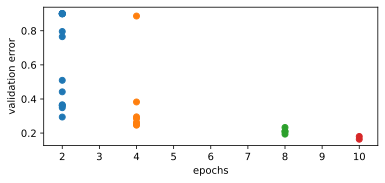

In [20]:
for rung_index, rung in scheduler.all_observed_error_at_rungs.items():
    errors = [xi[1] for xi in rung]
    d2l.plt.scatter([rung_index] * len(errors), errors)
d2l.plt.xlim(min_number_of_epochs - 0.5, max_number_of_epochs + 0.5)
d2l.plt.xticks(
    np.arange(min_number_of_epochs, max_number_of_epochs + 1),
    np.arange(min_number_of_epochs, max_number_of_epochs + 1),
)
d2l.plt.ylabel("validation error")
d2l.plt.xlabel("epochs")

# 19.5. Asynchronous Successive Halving 

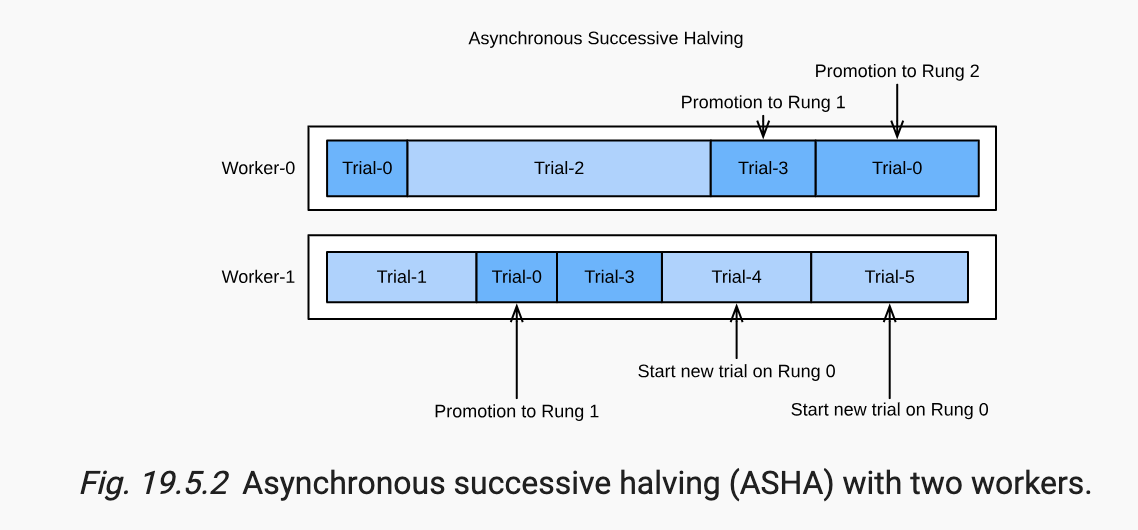

In [22]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter
    from d2l import torch as d2l

    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()
        validation_error = trainer.validation_error().cpu().detach().numpy()
        report(epoch=epoch, validation_error=float(validation_error))

In [23]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2

config_space = {
    "learning_rate": loguniform(1e-2, 1),
    "batch_size": randint(32, 256),
    "max_epochs": max_number_of_epochs,
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

In [24]:
n_workers = 2  # Needs to be <= the number of available GPUs
max_wallclock_time = 12 * 60  # 12 minutes

In [25]:
mode = "min"
metric = "validation_error"
resource_attr = "epoch"

scheduler = ASHA(
    config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
    max_resource_attr="max_epochs",
    resource_attr=resource_attr,
    grace_period=min_number_of_epochs,
    reduction_factor=eta,
)

INFO:syne_tune.optimizer.schedulers.scheduler_searcher:Master random_seed = 903390083
INFO:syne_tune.optimizer.schedulers.scheduler_searcher:max_resource_level = 10, as inferred from config_space


In [26]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/pqian/syne-tune/python-entrypoint-2025-06-03-00-16-17-554
INFO:syne_tune.backend.local_backend:Detected 1 GPUs
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/pqian/miniconda3/envs/llama3/bin/python /home/pqian/miniconda3/envs/llama3/lib/python3.11/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root /home/pqian/syne-tune/python-entrypoint-2025-06-03-00-16-17-554/tune_function --tune_function_hash 3b9fec3ee3a5527b2f41330d374437c8 --st_checkpoint_dir /home/pqian/syne-tune/python-entrypoint-2025-06-03-00-16-17-554/0/checkpoints
INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/pqian/miniconda3/envs/llama3/bin/python /home/pqian/miniconda3/envs/llama3/lib/python3.11/site-packages

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0    Stopped     4       0.100000         128          10    4.0          0.622132     6.964670
        1  Completed    10       0.037975         214          10   10.0          0.840916    14.641587
        2  Completed    10       0.139747         148          10   10.0          0.316948    13.927291
        3  Completed    10       0.044423          40          10   10.0          0.240300    30.005115
        4    Stopped     6       0.068859         251          10    6.0          0.899945     7.900795
        5  Completed    10       0.053619          93          10   10.0          0.298942    19.738953
        6    Stopped    10       0.106934         245          10   10.0          0.406449    12.770596
        7    Stopped     6       0.082237         252          10    6.0          0.900055     7.978458

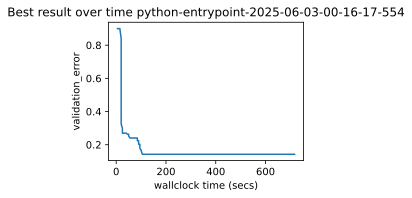

In [27]:
d2l.set_figsize()
e = load_experiment(tuner.name)
e.plot()

Text(0, 0.5, 'objective function')

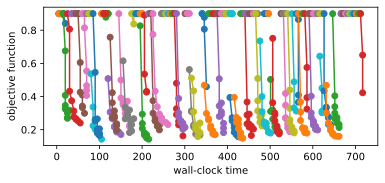

In [28]:
d2l.set_figsize([6, 2.5])
results = e.results
for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]
    d2l.plt.plot(df["st_tuner_time"], df["validation_error"], marker="o")
d2l.plt.xlabel("wall-clock time")
d2l.plt.ylabel("objective function")